In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [28]:
def calculate_metrics(FP, FN, TP, TN):
    P = TP + FN
    N = TN + FP

    TPR = TP/P if P != 0 else 0
    TNR = TN/N if N != 0 else 0
    FPR = FP/N if N != 0 else 0
    FNR = FN/P if P != 0 else 0

    recall = TPR
    precision = TP/(TP+FP) if (TP+FP) != 0 else 0
    F1 = (2*TP)/(2*TP+FP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    error_rate = (FP+FN)/(TP+TN+FP+FN)

    BACC = (TPR+TNR)/2
    TSS = (TP/(TP+FN))-(FP/(FP+TN))
    HSS = (2*((TP*TN)-(FP*FN)))/(((TP+FN)*(FN+TN)) + ((TP+FP)*(FP+TN)))

    return {
        'TPR': TPR,
        'TNR': TNR,
        'FPR': FPR,
        'FNR': FNR,
        'Recall': recall,
        'Precision': precision,
        'F1': F1,
        'Accuracy': accuracy,
        'Error Rate': error_rate,
        'BACC': BACC,
        'TSS': TSS,
        'HSS': HSS
    }

In [29]:
def random_forest(X_train, X_test, y_train, y_test):
    rf  = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test,y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    return {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    }

In [30]:
def support_vector_machine(X_train, X_test, y_train, y_test):
    clf = svm.SVC(kernel='linear', probability=True) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test,y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)  

    return {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    } 

In [31]:
def lstm(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define the LSTM model with Input layer
    lstm_model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict and convert probabilities to binary labels
    y_pred_prob = lstm_model.predict(X_test)
    brier_score = brier_score_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)          
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    return {
        'y_pred': y_pred,
        'y_prob': y_pred_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    }

In [32]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def k_fold(X, Y, K, model):
    kf = KFold(n_splits=K, shuffle = True, random_state=42)
    metrics_list = []
    cumulative_cm = np.zeros((2, 2), dtype=int)
    all_y_true = []
    all_y_prob = []

    for i, (train_index, test_index) in enumerate(kf.split(X), start = 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        if model == 'Random Forest':
            rf = random_forest(X_train, X_test, y_train, y_test)
            y_pred = rf['y_pred']
            y_prob = rf['y_prob']
            brier_score = rf['brier_score']
            roc_auc = rf['roc_auc']

            all_y_true.extend(y_test)
            all_y_prob.extend(y_prob)
        elif model == 'SVM':
            clf = support_vector_machine(X_train, X_test, y_train, y_test)
            y_pred = clf['y_pred']
            y_prob = clf['y_prob']
            brier_score = clf['brier_score']
            roc_auc = clf['roc_auc']       
            
            all_y_true.extend(y_test)
            all_y_prob.extend(y_prob)
        elif model == 'LSTM':
            lstm_results = lstm(X_train,X_test, y_train, y_test)
            y_pred = lstm_results['y_pred']
            y_pred_prob = lstm_results['y_prob']
            brier_score = lstm_results['brier_score']
            roc_auc = lstm_results['roc_auc']

            all_y_true.extend(y_test)
            all_y_prob.extend(y_pred_prob)

        cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
        TP = cm[0, 0]
        FN = cm[0, 1]
        FP = cm[1, 0]
        TN = cm[1, 1]

        cumulative_cm += cm # Add current fold's confusion matrix to the cumulative matrix

        fold_metrics = calculate_metrics(FP,FN,TP,TN)
        fold_metrics['Fold'] = i
        fold_metrics['Brier Score'] = brier_score
        fold_metrics['AUC'] = roc_auc
        metrics_list.append(fold_metrics)
    
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.set_index('Fold', inplace=True)

    avg_metrics = metrics_df.mean().to_dict()
    avg_metrics['Fold'] = 'Average'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics]).set_index('Fold')])

    print(f"Metrics Table Across All Folds for {model}:\n")
    print(metrics_df)

    disp = ConfusionMatrixDisplay(confusion_matrix=cumulative_cm, display_labels=[1, 0])
    disp.plot(cmap='Blues')
    plt.title('Cumulative Confusion Matrix After All Folds')
    plt.show()

    roc_auc = roc_auc_score(all_y_true, all_y_prob)
    fpr, tpr, threshold = roc_curve(all_y_true, all_y_prob)

    plot_roc(fpr,tpr,roc_auc)

    return metrics_df

Metrics Table Across All Folds for Random Forest:

              TPR       TNR       FPR       FNR    Recall  Precision  \
Fold                                                                   
1        0.823529  0.714286  0.285714  0.176471  0.823529   0.777778   
2        0.937500  1.000000  0.000000  0.062500  0.937500   1.000000   
3        0.789474  0.666667  0.333333  0.210526  0.789474   0.789474   
4        0.777778  0.833333  0.166667  0.222222  0.777778   0.875000   
5        0.923077  0.764706  0.235294  0.076923  0.923077   0.750000   
6        0.944444  0.583333  0.416667  0.055556  0.944444   0.772727   
7        0.933333  0.600000  0.400000  0.066667  0.933333   0.700000   
8        0.888889  0.750000  0.250000  0.111111  0.888889   0.842105   
9        0.800000  0.866667  0.133333  0.200000  0.800000   0.857143   
10       0.875000  0.785714  0.214286  0.125000  0.875000   0.823529   
Average  0.869302  0.756471  0.243529  0.130698  0.869302   0.818776   

            

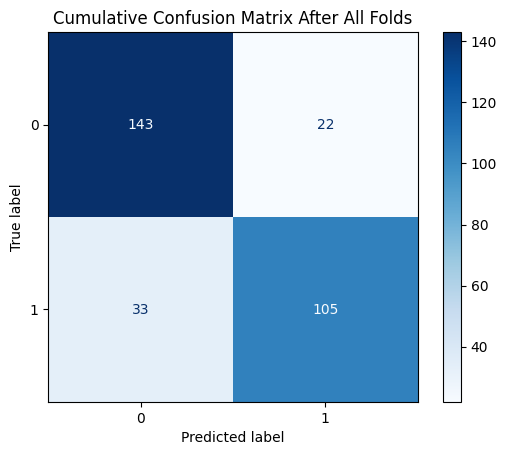

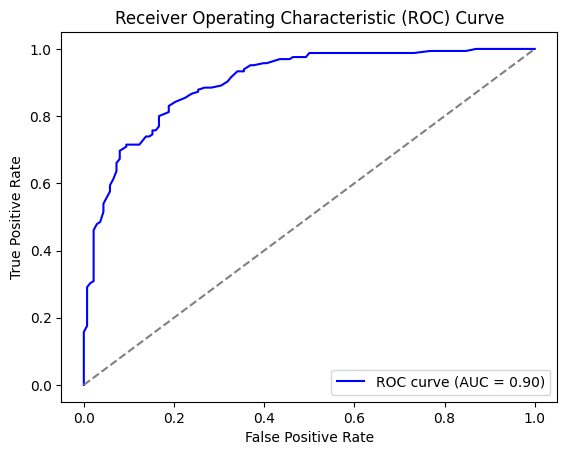

In [34]:
data = pd.read_csv("Data/heart.csv")
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)

X = data.drop('target', axis=1)
Y = data['target']

avg = k_fold(X,Y,10, 'Random Forest')


Metrics Table Across All Folds for SVM:

              TPR       TNR       FPR       FNR    Recall  Precision  \
Fold                                                                   
1        0.882353  0.785714  0.214286  0.117647  0.882353   0.833333   
2        0.937500  0.933333  0.066667  0.062500  0.937500   0.937500   
3        0.842105  0.583333  0.416667  0.157895  0.842105   0.761905   
4        0.888889  0.750000  0.250000  0.111111  0.888889   0.842105   
5        0.923077  0.764706  0.235294  0.076923  0.923077   0.750000   
6        0.944444  0.750000  0.250000  0.055556  0.944444   0.850000   
7        0.866667  0.600000  0.400000  0.133333  0.866667   0.684211   
8        1.000000  0.583333  0.416667  0.000000  1.000000   0.782609   
9        0.866667  0.866667  0.133333  0.133333  0.866667   0.866667   
10       0.937500  0.785714  0.214286  0.062500  0.937500   0.833333   
Average  0.908920  0.740280  0.259720  0.091080  0.908920   0.814166   

               F1  Acc

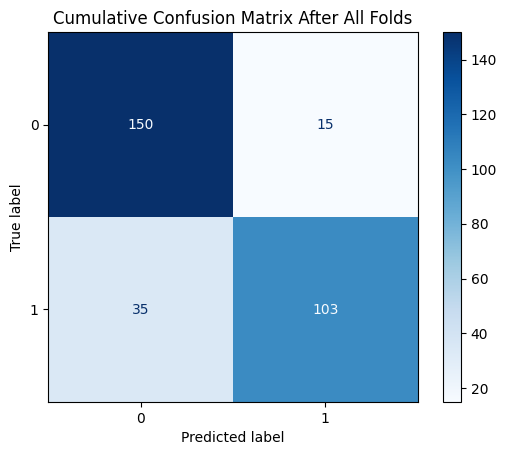

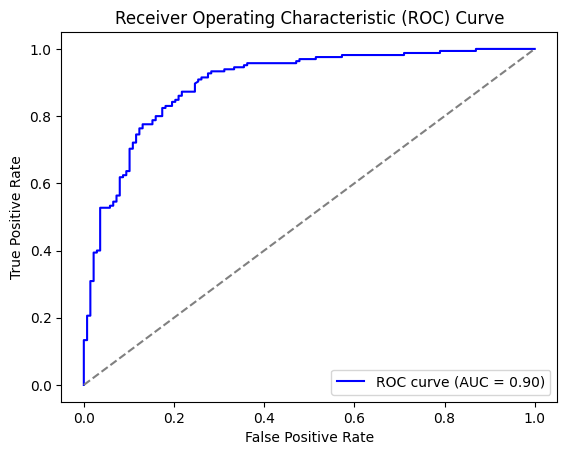

In [35]:
avg = k_fold(X,Y,10, 'SVM')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Metrics Table Across All Folds for LSTM:

              TPR       TNR       FPR       FNR    Recall  Precision  \
Fold                                                                   
1        0.882353  0.785714  0.214286  0.117647  0.882353   0.833333   
2        0.937500  0.933333  0.066667  0.062500  0.937500   0.937500   
3        0.894737  0.666667  0.333333  0.105263  0.894737   0.809524   
4        0.833333  0.833333  0.166667  0.166667  0.833333   0.882353   
5        0.923077  0.882353  0.117647  0.076923  0.923077   0.857143   
6        0.888889  0.750000  0.250000  0.111111  0.888889   0.842105   
7 

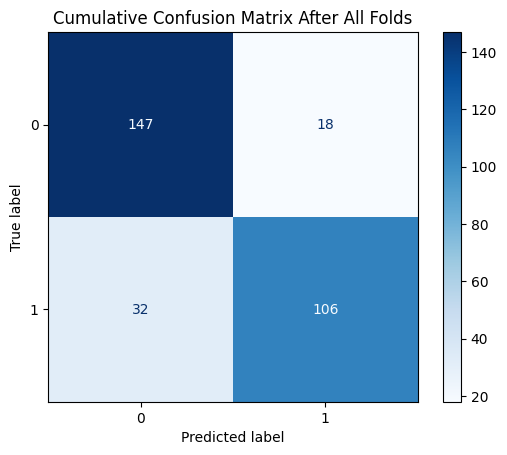

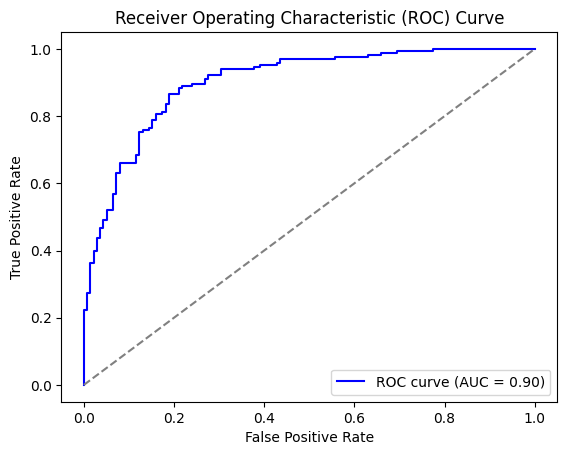

In [36]:
avg = k_fold(X,Y,10, 'LSTM')